In [1]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Reading and preprocessing data

# Reading the data into a pandas dataframe
adult_data = pd.read_csv("adult.csv", delimiter=", ")
adult_df = pd.DataFrame(adult_data)

# Checking missing values
adult_df.replace("?", np.nan, inplace=True)
adult_df.isna().sum()

# Converting income values into 0 and 1 to keep track of them
adult_df["income"] = adult_df["income"].str.strip().apply(lambda x: 0 if x == "<=50K" else 1)

/tmp/ipykernel_37085/1667499852.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  adult_data = pd.read_csv("adult.csv", delimiter=", ")


In [3]:
# Splitting data into features and target variable
X = adult_df.drop("income", axis=1)
y = adult_df["income"]

In [4]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Identifying categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [6]:
# Handling missing data

# OPTION 1: Removing Rows with Missing Values
X_train_no_missing = X_train.dropna()
X_test_no_missing = X_test.dropna()

# OPTION 2: Mode Imputation
mode_imputer = SimpleImputer(strategy='most_frequent')
X_train_mode = X_train.copy()
X_test_mode = X_test.copy()
X_train_mode[categorical_cols] = mode_imputer.fit_transform(X_train[categorical_cols])
X_test_mode[categorical_cols] = mode_imputer.transform(X_test[categorical_cols])

# OPTION 3: KNN Imputation
# Add "missing" category and encode
X_train_knn = X_train.copy()
X_test_knn = X_test.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Explicitly include "missing" in the categories
    unique_values = list(X_train[col].dropna().unique()) + ["missing"]
    le.fit(unique_values)
    X_train_knn[col] = X_train_knn[col].fillna("missing")
    X_test_knn[col] = X_test_knn[col].fillna("missing")
    X_train_knn[col] = le.transform(X_train_knn[col])
    X_test_knn[col] = le.transform(X_test_knn[col])
    label_encoders[col] = le

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
X_train_knn = pd.DataFrame(knn_imputer.fit_transform(X_train_knn), columns=X_train_knn.columns)
X_test_knn = pd.DataFrame(knn_imputer.transform(X_test_knn), columns=X_test_knn.columns)

# Reverse label encoding
for col in categorical_cols:
    le = label_encoders[col]
    missing_label = le.transform(["missing"])[0]
    
    # Handle NaN values before applying inverse_transform
    X_train_knn[col] = X_train_knn[col].round().astype(int)
    X_train_knn[col] = X_train_knn[col].replace(missing_label, np.nan)
    
    # Temporarily replace NaN for inverse_transform
    temp_col = X_train_knn[col].fillna(missing_label).astype(int)
    X_train_knn[col] = le.inverse_transform(temp_col)
    X_train_knn[col] = X_train_knn[col].replace("missing", np.nan)
    
    # Repeat the same for the test set
    X_test_knn[col] = X_test_knn[col].round().astype(int)
    X_test_knn[col] = X_test_knn[col].replace(missing_label, np.nan)
    
    temp_col = X_test_knn[col].fillna(missing_label).astype(int)
    X_test_knn[col] = le.inverse_transform(temp_col)
    X_test_knn[col] = X_test_knn[col].replace("missing", np.nan)

In [7]:
# Preprocessing pipeline for categorical columns using one-hot encoding (for knn classifier)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers in a column transformer (only for categorical columns)
preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_cols)],
    remainder='passthrough'
)

# Fit preprocessor only on the training data
preprocessor.fit(X_train)

# Transform all three datasets (so knn classifier can classify them)
X_train_no_missing_transformed = preprocessor.transform(X_train_no_missing)
X_test_no_missing_transformed = preprocessor.transform(X_test_no_missing)

X_train_mode_transformed = preprocessor.transform(X_train_mode)
X_test_mode_transformed = preprocessor.transform(X_test_mode)

X_train_knn_transformed = preprocessor.transform(X_train_knn)
X_test_knn_transformed = preprocessor.transform(X_test_knn)

In [8]:
# Pipelines (to make predicitons) for each method 
pipeline_no_missing = Pipeline(steps=[
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])
pipeline_mode = Pipeline(steps=[
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])
pipeline_knn = Pipeline(steps=[
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

In [9]:
# Training the models and predicting
pipeline_no_missing.fit(X_train_no_missing_transformed, y_train.loc[X_train_no_missing.index])
y_prob_no_missing = pipeline_no_missing.predict_proba(X_test_no_missing_transformed)[:, 1]

pipeline_mode.fit(X_train_mode_transformed, y_train)
y_prob_mode = pipeline_mode.predict_proba(X_test_mode_transformed)[:, 1]

pipeline_knn.fit(X_train_knn_transformed, y_train)
y_prob_knn = pipeline_knn.predict_proba(X_test_knn_transformed)[:, 1]

In [10]:
# Predict again, just to compute metrics
y_pred_no_missing = pipeline_no_missing.predict(X_test_no_missing_transformed)
y_pred_mode = pipeline_mode.predict(X_test_mode_transformed)
y_pred_knn = pipeline_knn.predict(X_test_knn_transformed)

# Accuracy scores
accuracy_no_missing = accuracy_score(y_test.loc[X_test_no_missing.index], y_pred_no_missing)
accuracy_mode = accuracy_score(y_test, y_pred_mode)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Print accuracy results
print(f"Accuracy with Removing Missing Data: {accuracy_no_missing:.4f}")
print(f"Accuracy with Mode Imputation: {accuracy_mode:.4f}")
print(f"Accuracy with KNN Imputation: {accuracy_knn:.4f}")

# Classification reports
print("\nClassification Report for Removing Missing Data:")
print(classification_report(y_test.loc[X_test_no_missing.index], y_pred_no_missing))

print("\nClassification Report for Mode Imputation:")
print(classification_report(y_test, y_pred_mode))

print("\nClassification Report for KNN Imputation:")
print(classification_report(y_test, y_pred_knn))


Accuracy with Removing Missing Data: 0.7687
Accuracy with Mode Imputation: 0.7786
Accuracy with KNN Imputation: 0.7786

Classification Report for Removing Missing Data:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      4506
           1       0.56      0.32      0.41      1499

    accuracy                           0.77      6005
   macro avg       0.68      0.62      0.63      6005
weighted avg       0.74      0.77      0.74      6005


Classification Report for Mode Imputation:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      4942
           1       0.57      0.33      0.42      1571

    accuracy                           0.78      6513
   macro avg       0.69      0.62      0.64      6513
weighted avg       0.75      0.78      0.76      6513


Classification Report for KNN Imputation:
              precision    recall  f1-score   support

           0       0.81      0.92  

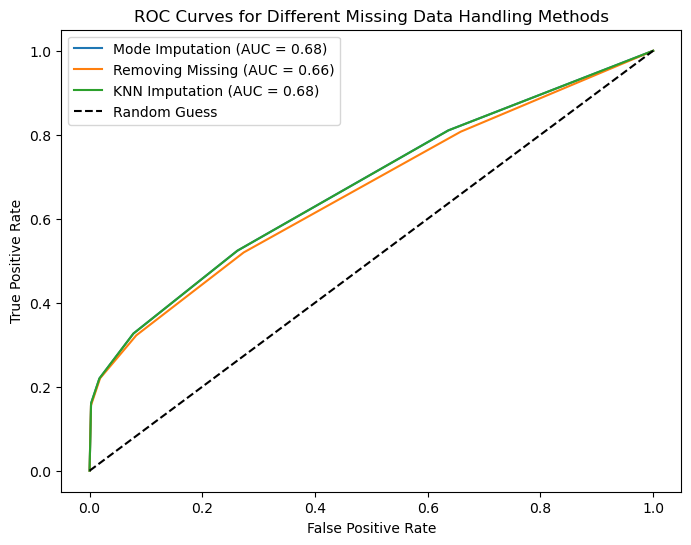

In [11]:
# AUC-ROC Scores
roc_auc_mode = roc_auc_score(y_test, y_prob_mode)
roc_auc_no_missing = roc_auc_score(y_test.loc[X_test_no_missing.index], y_prob_no_missing)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

# Plot ROC Curves
fpr_mode, tpr_mode, _ = roc_curve(y_test, y_prob_mode)
fpr_no_missing, tpr_no_missing, _ = roc_curve(y_test.loc[X_test_no_missing.index], y_prob_no_missing)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mode, tpr_mode, label=f'Mode Imputation (AUC = {roc_auc_mode:.2f})')
plt.plot(fpr_no_missing, tpr_no_missing, label=f'Removing Missing (AUC = {roc_auc_no_missing:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN Imputation (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Missing Data Handling Methods')
plt.legend()
plt.show()

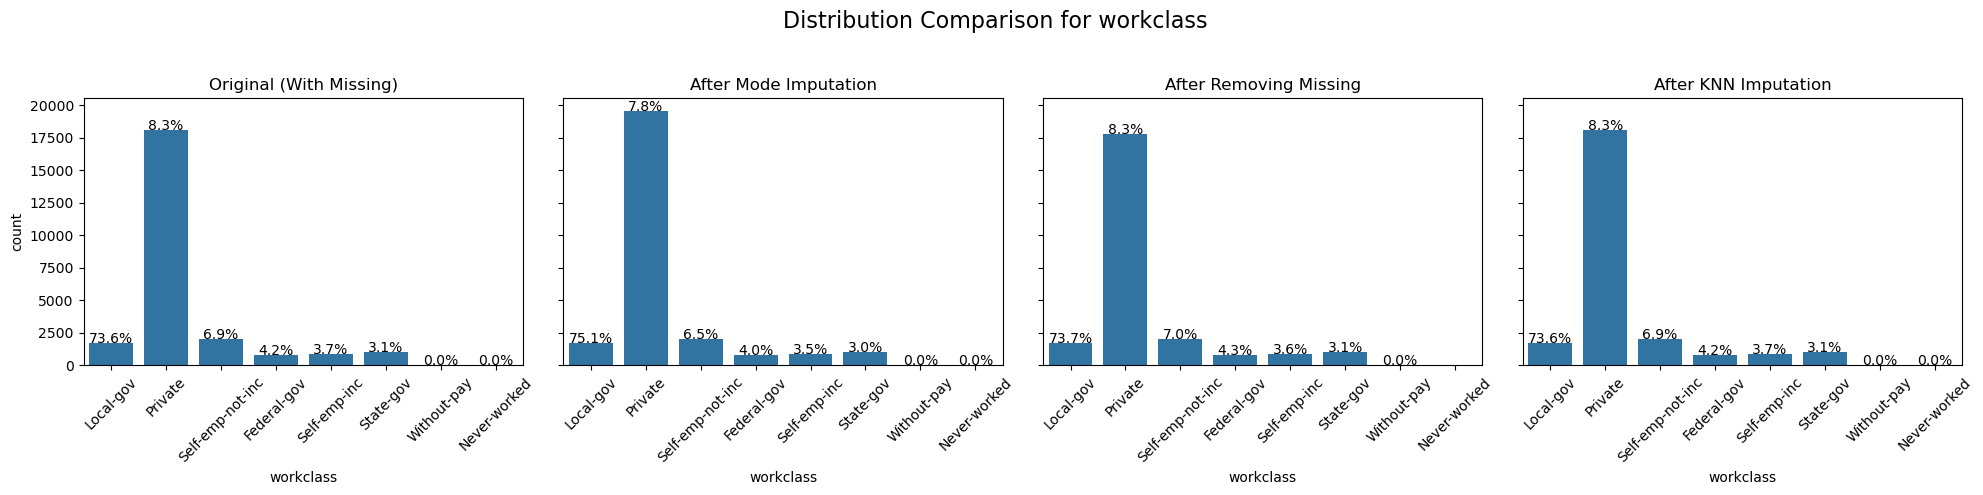

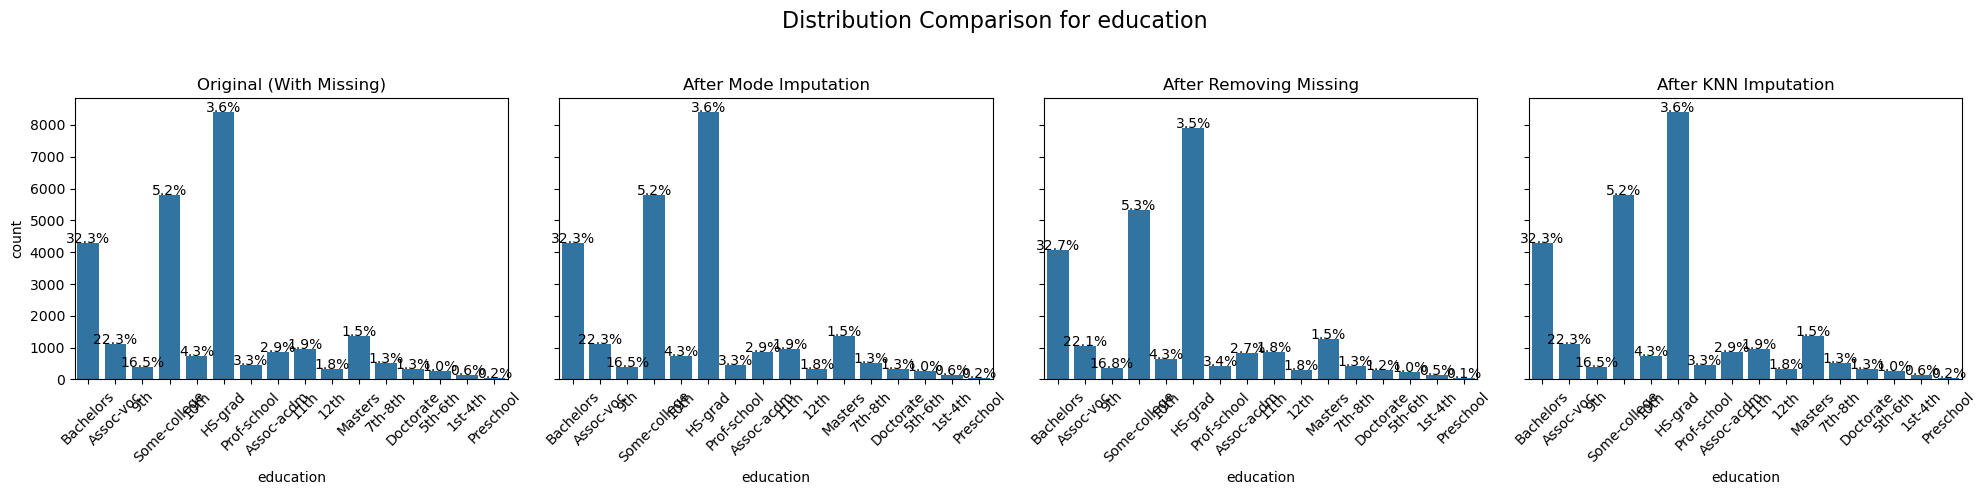

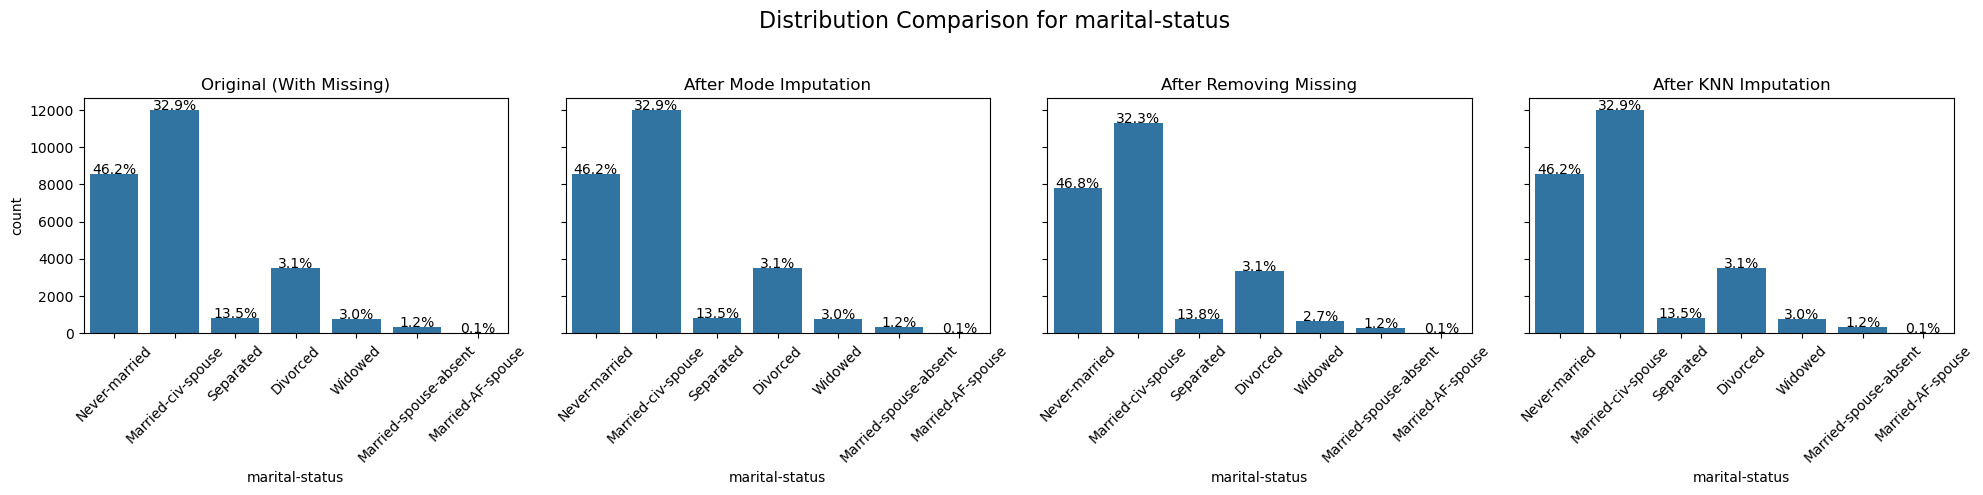

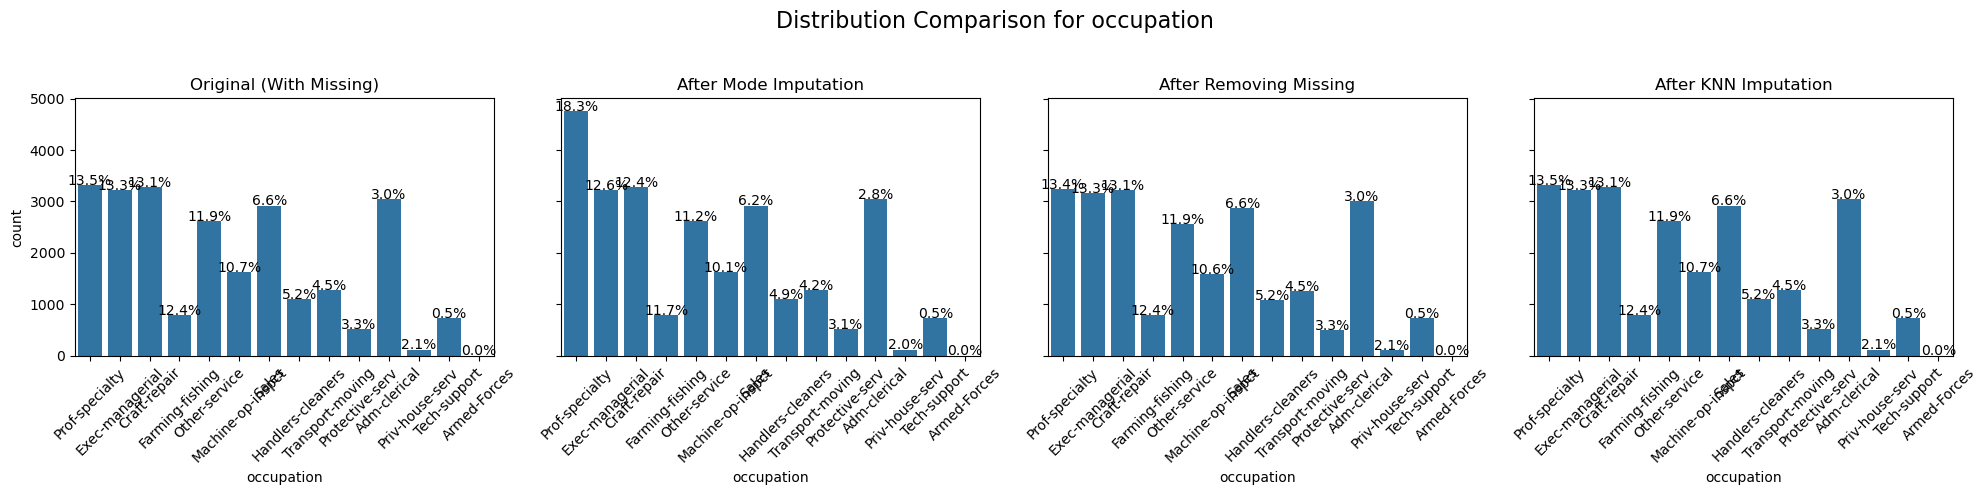

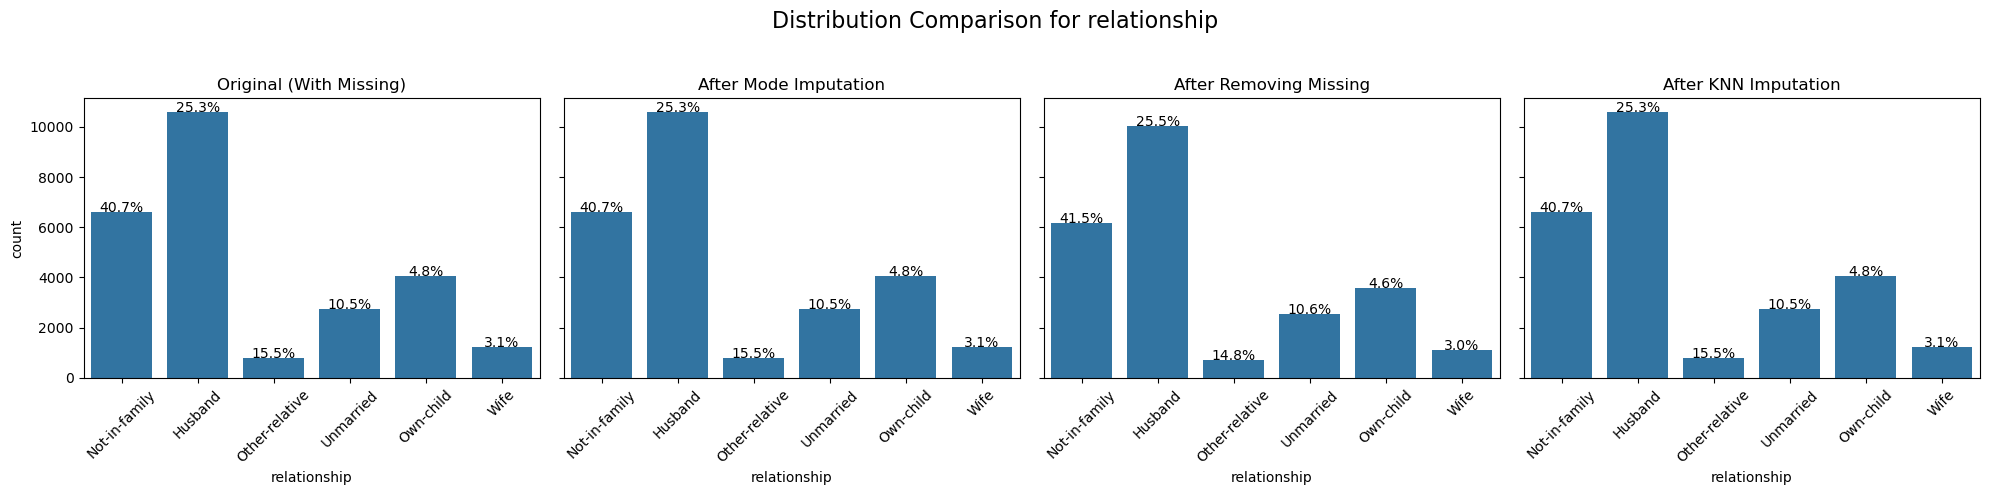

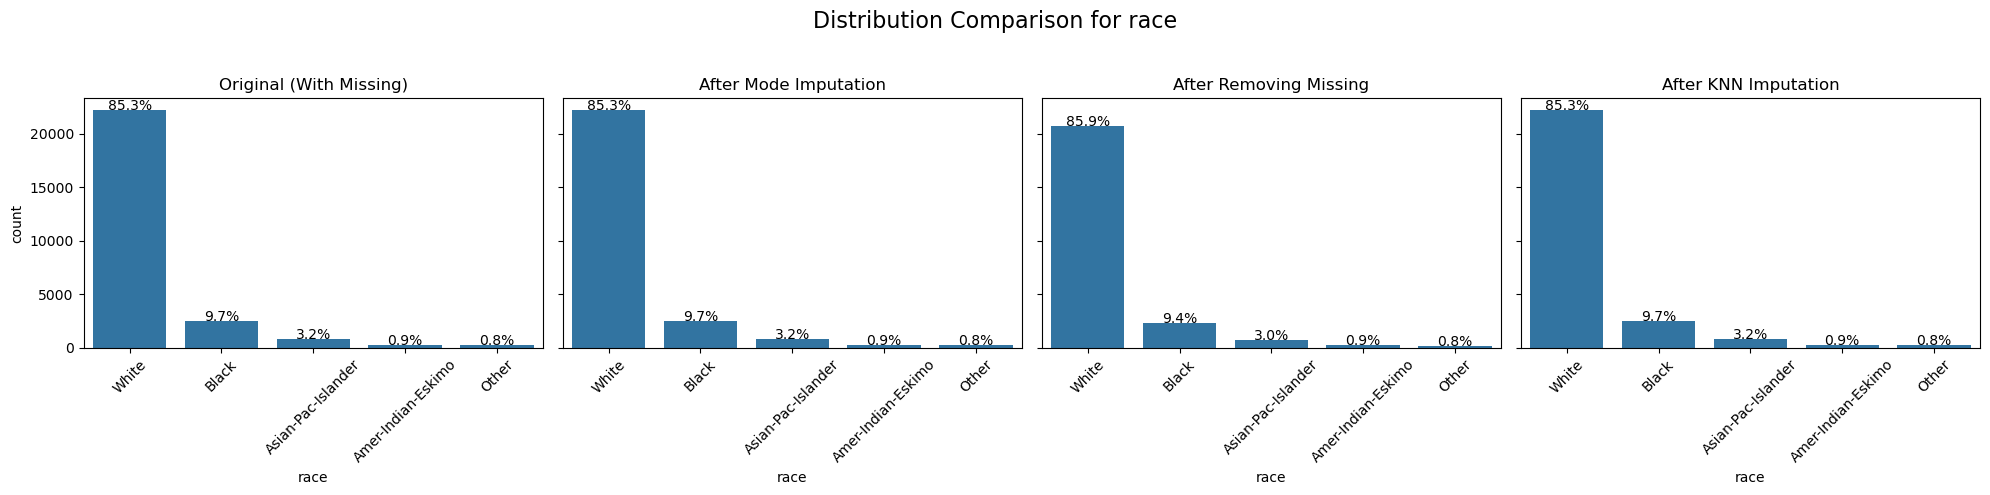

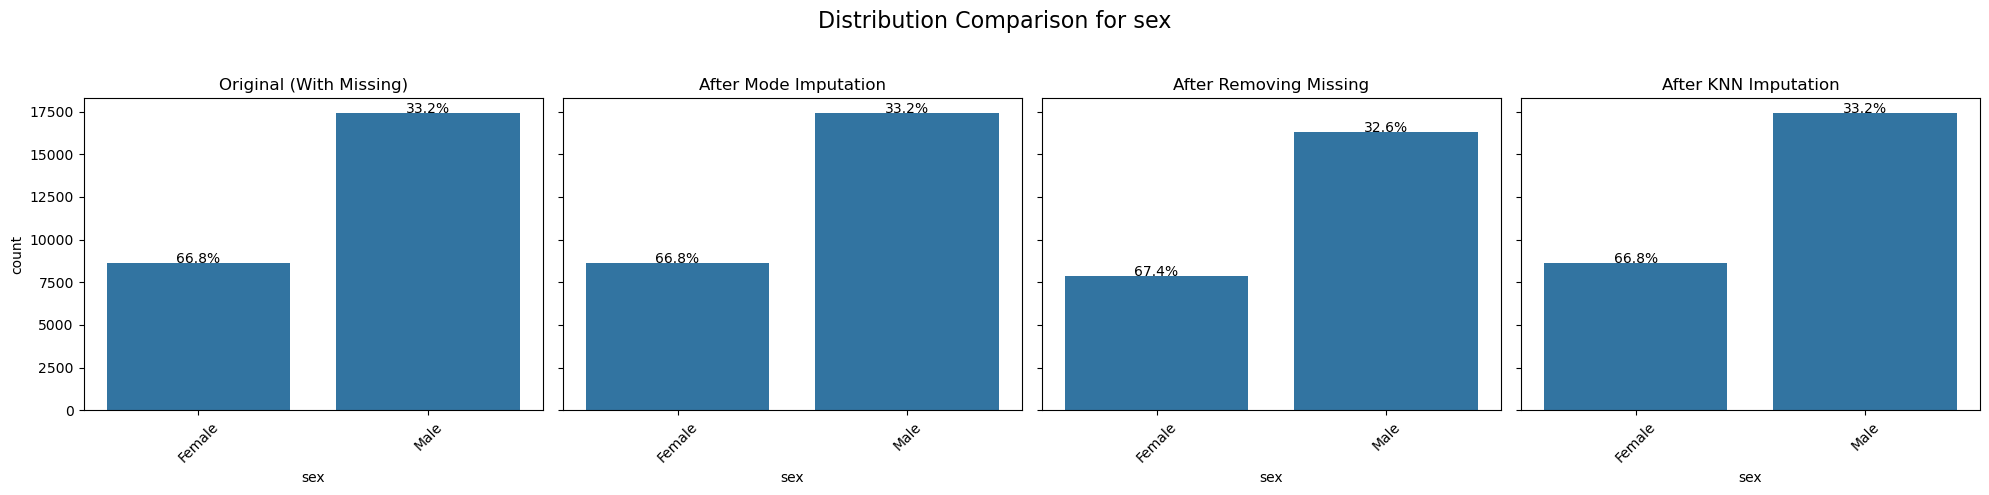

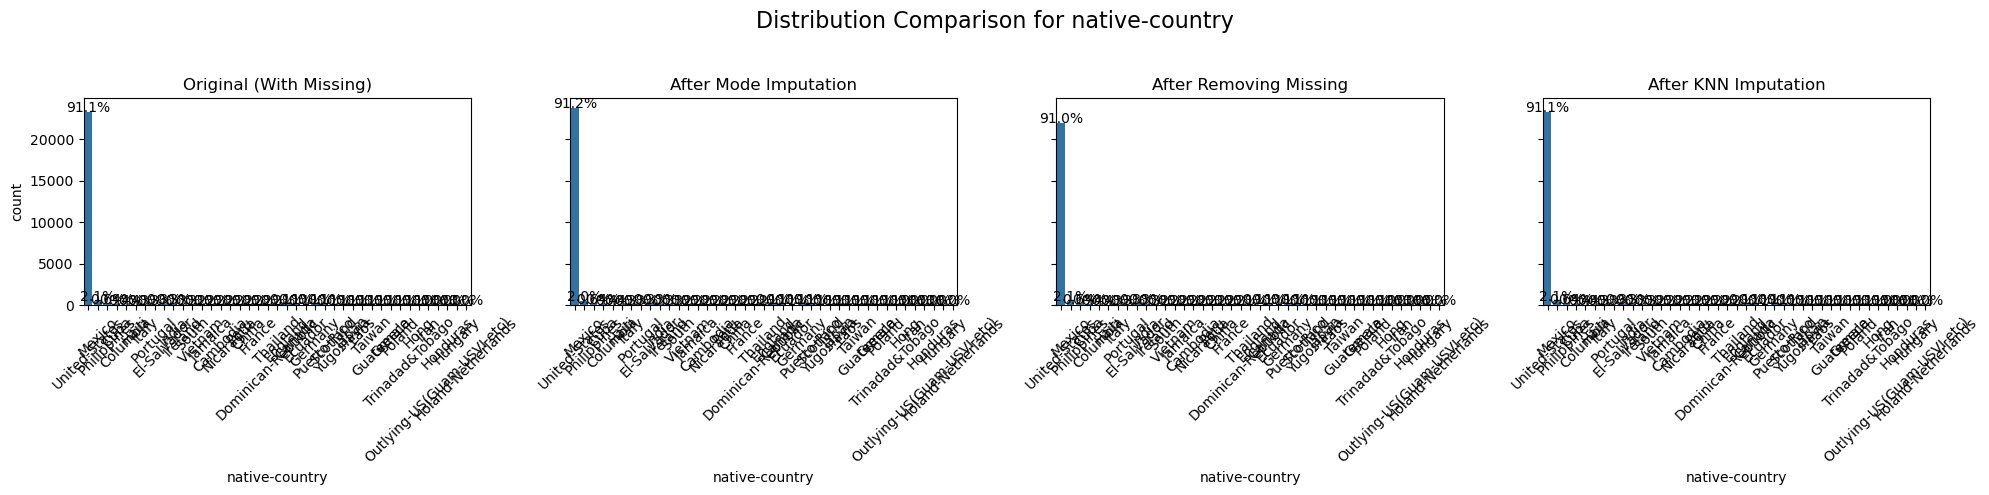

In [12]:
# Plots for comparing feature distribution

def plot_feature_distributions_with_percentages(X_original, X_mode, X_no_missing, X_knn, columns):
    """
    Compare feature distributions across original, mode-imputed, no-missing, and KNN-imputed datasets.

    Parameters:
    - X_original: Original dataset (with missing values).
    - X_mode: Dataset after Mode Imputation.
    - X_no_missing: Dataset after Removing Missing Rows.
    - X_knn: Dataset after KNN Imputation.
    - columns: List of columns to compare.
    """
    for col in columns:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
        fig.suptitle(f'Distribution Comparison for {col}', fontsize=16)

        datasets = {
            'Original (With Missing)': X_original,
            'After Mode Imputation': X_mode,
            'After Removing Missing': X_no_missing,
            'After KNN Imputation': X_knn
        }

        for i, (title, dataset) in enumerate(datasets.items()):
            value_counts = dataset[col].value_counts(normalize=True) * 100
            order = X_original[col].dropna().unique()

            ax = sns.countplot(x=col, data=dataset, ax=axes[i], order=order)
            ax.set_title(title)
            ax.tick_params(axis='x', rotation=45)
            for bar, label in zip(ax.patches, value_counts):
                ax.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height() + 1,
                        f'{label:.1f}%', ha='center', fontsize=10)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Apply the function for categorical columns
plot_feature_distributions_with_percentages(
    X_train, X_train_mode, X_train_no_missing, X_train_knn, categorical_cols
)
